In [25]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # See issue #152 stack-overflow.
  #  accessible = '"' + ','.join(str(e) for e in accessible) + '"'
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10344723675096166333, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 209715200
 locality {
   bus_id: 2
 }
 incarnation: 11531565211377806580
 physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:82:00.0"]

In [26]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

GEO_TOOL_BASE_DIR = '/orions4-zfs/projects/lins2/Lin_Space/Git_Repos/'
sys.path.append(GEO_TOOL_BASE_DIR)

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet

from tf_lab.point_clouds.vae import VariationalAutoencoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from general_tools.in_out.basics import create_dir, delete_files_in_directory
from geo_tool import Point_Cloud

from general_tools.in_out.basics import files_in_subdirs
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
class_type = raw_input('Give me the class type.').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]
experiment_name = 'bernoulli_1.0_full_shapes_' + class_syn_id + '_vae'

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/', class_syn_id)
train_dir = osp.join(top_data_dir, 'OUT/models/')

train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/bernoulli_1.0_full_shapes_03001627_vae'

In [29]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=11)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [30]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds, full_model_names],
                                                                   train_perc=0.9,
                                                                   validate_perc=0.0,
                                                                   test_perc=0.1,                                                                   
                                                                   seed=seed)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [31]:
import tf_lab.models.point_net_based_AE as pnAE

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


conf = Conf(n_input = [1024, 3],
            training_epochs = 20,
            batch_size = 30,
            loss = 'bernoulli',
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 5,
            learning_rate = 0.00002,
            saver_max_to_keep = 200,
            gauss_augment = {'mu': 0, 'sigma': 0.02},
            encoder = pnAE.encoder,
            decoder = pnAE.decoder,
            spatial_trans = True,             
            denoising = False,
            n_z = 512,
            latent_vs_recon = 1.0,
            z_rotate = True
            )

reset_graph()

ae = VariationalAutoencoder(experiment_name, conf)
ae.train(train_data, conf)

[-0.74900115]
[-0.91677034]
[ 0.21547402]
[ 0.82157379]
[-0.55312061]
[-0.94410521]
[-0.32595897]
[ 0.14893325]
[-0.92492664]
[ 0.65154463]
[ 1.52799606]
[ 1.12790287]
[ 0.12168163]
[-0.71044511]
[ 0.16956985]
[-0.22490066]
[-1.97519827]
[-0.64083093]
[ 0.12429543]
[-0.80646193]
[-0.44150925]
[-0.86543095]
[ 0.83596826]
[-0.29196233]
[ 0.54679257]
[-2.76362491]
[-0.9370991]
[ 0.10746968]
[ 1.72458029]
[ 1.93717766]
[-1.17006028]
[-0.05761577]
[-0.65970153]
[ 2.3476119]
[ 1.39140213]
[-0.03634901]
[ 1.6031152]
[-1.43329811]
[ 0.29850402]
[-0.61663705]
[-0.51507694]
[-0.6358273]
[-0.56100023]
[-0.24423049]
[-0.57598853]
[ 1.2288425]
[-0.53081185]
[ 1.42231262]
[-0.21517357]
[ 1.91556883]
[ 1.44028914]
[ 1.12747276]
[ 0.2333912]
[ 0.344349]
[ 1.25677443]
[ 0.96732634]
[-1.7805469]
[ 0.82851923]
[-0.7005623]
[-2.47241664]
[-0.5069856]
[ 1.3154763]
[ 0.26152369]
[-0.16497666]
[ 0.0299235]
[-0.46677831]
[-0.76343155]
[ 0.73740405]
[ 0.29057956]
[ 0.75416303]
[ 0.42129526]
[ 0.50556487]
[-0.7

KeyboardInterrupt: 

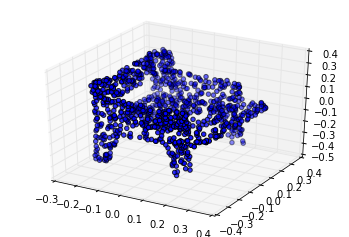

In [16]:
tmp = train_data.next_batch(40)[0][3].reshape(1024,3)
pc_tmp = Point_Cloud(points=tmp).plot()